In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import altair as alt
from tqdm.notebook import tqdm
from typing import List, Tuple, Union

import candle
import candle.functions as F
from candle import utils

## Experiment 1: Activation Distributions w.r.t. Various Inits

In [3]:
DEPTH = 10
HIDDEN_SIZE = 4096

In [4]:
kaiming_init_linear_layers = [candle.Linear(HIDDEN_SIZE, HIDDEN_SIZE) for _ in range(DEPTH)]

for linear_layer in kaiming_init_linear_layers:
    linear_layer.W = candle.Tensor(utils.kaiming_init(HIDDEN_SIZE, HIDDEN_SIZE))

xavier_init_linear_layers = [candle.Linear(HIDDEN_SIZE, HIDDEN_SIZE) for _ in range(DEPTH)]

for linear_layer in xavier_init_linear_layers:
    linear_layer.W = candle.Tensor(utils.xavier_init(HIDDEN_SIZE, HIDDEN_SIZE))

In [5]:
def get_layer_activations(linear_layers, apply_relu: bool):
    x = candle.Tensor(np.random.normal(size=(16, HIDDEN_SIZE)))

    layer_activations = []
    for linear_layer in linear_layers:
        x = linear_layer(x)
        layer_activations.append(x.data)
        if apply_relu:
            x = F.relu(x)
        
    return layer_activations

### Kaiming Init, ReLU

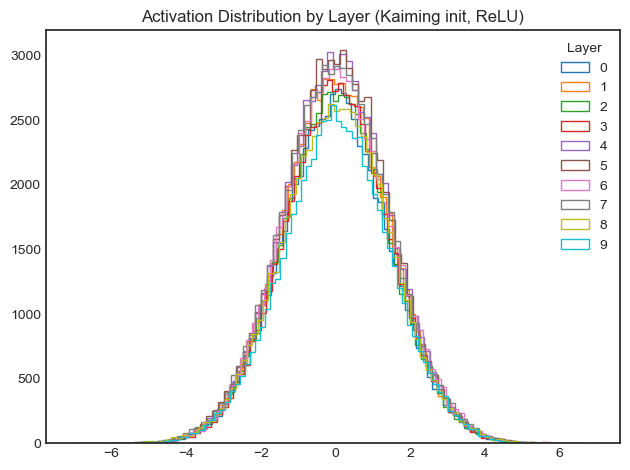

In [6]:
layer_activations = get_layer_activations(kaiming_init_linear_layers, apply_relu=True)

for (layer_i, activation) in enumerate(layer_activations):
    plt.hist(activation.flatten(), bins=80, histtype='step', label=layer_i)
plt.legend(title='Layer')
plt.title('Activation Distribution by Layer (Kaiming init, ReLU)')
plt.tight_layout()
plt.show()

### Kaiming Init, no ReLU

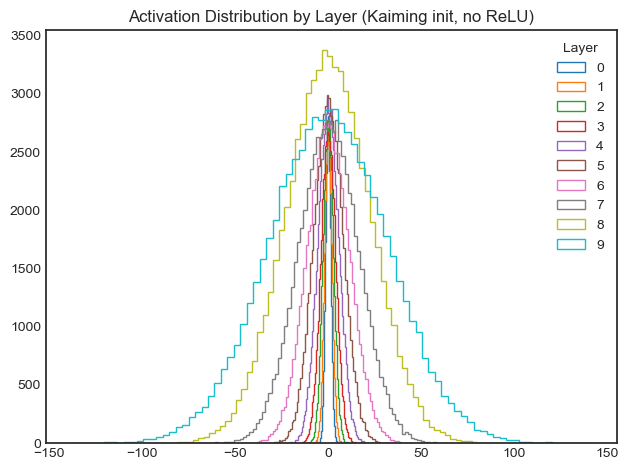

In [7]:
layer_activations = get_layer_activations(kaiming_init_linear_layers, apply_relu=False)

for (layer_i, activation) in enumerate(layer_activations):
    plt.hist(activation.flatten(), bins=80, histtype='step', label=layer_i)
plt.legend(title='Layer')
plt.title('Activation Distribution by Layer (Kaiming init, no ReLU)')
plt.tight_layout()
plt.show()

### Xavier Init, ReLU

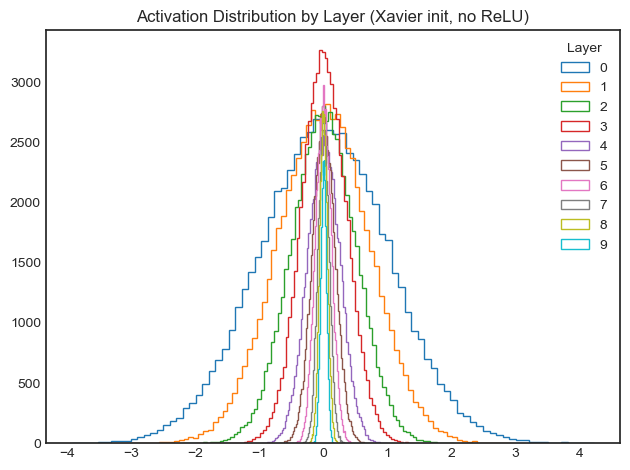

In [8]:
layer_activations = get_layer_activations(xavier_init_linear_layers, apply_relu=True)

for (layer_i, activation) in enumerate(layer_activations):
    plt.hist(activation.flatten(), bins=80, histtype='step', label=layer_i)
plt.legend(title='Layer')
plt.title('Activation Distribution by Layer (Xavier init, no ReLU)')
plt.tight_layout()
plt.show()

### Xavier Init, no ReLU

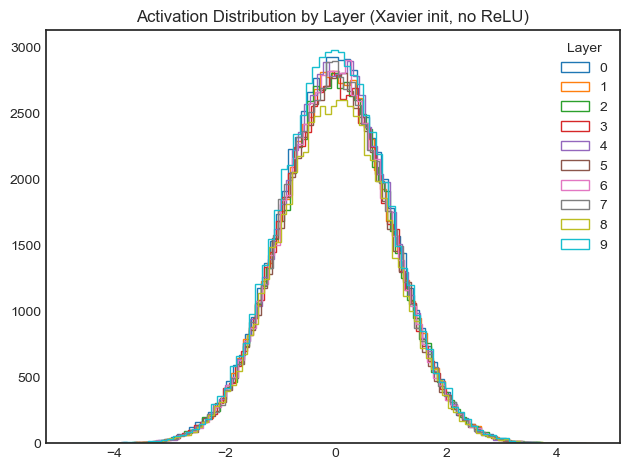

In [9]:
layer_activations = get_layer_activations(xavier_init_linear_layers, apply_relu=False)

for (layer_i, activation) in enumerate(layer_activations):
    plt.hist(activation.flatten(), bins=80, histtype='step', label=layer_i)
plt.legend(title='Layer')
plt.title('Activation Distribution by Layer (Xavier init, no ReLU)')
plt.tight_layout()
plt.show()

## Experiment 2: Activation Distributions by Layer over Training Iteration

In [10]:
class MLP(candle.Module):
    
    def __init__(self,
                 depth: int,
                 width: int,
                 initialization: str,
                 init_scale: float = 1.0):
        super().__init__()
        
        self.linear_layers = candle.ParameterList([
            candle.Linear(width, width)
            for _ in range(depth)
        ])
        self.output_layer = candle.Linear(width, 1)
        
        assert initialization in ['kaiming', 'xavier']
        if initialization == 'kaiming':
            for linear_layer in self.linear_layers:
                linear_layer.W.data = init_scale * utils.kaiming_init(width, width)
        elif initialization == 'xavier':
            for linear_layer in self.linear_layers:
                linear_layer.W.data = init_scale * utils.xavier_init(width, width)
                
    def forward(self, x):
        activation_stds = []
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
            activation_stds.append(x.data.std())
            x = F.relu(x)
        x = self.output_layer(x)[:, 0]
        
        return (x, activation_stds)

In [11]:
def plot_activation_distribution_and_loss(initialization: str,
                                          depth: int,
                                          width: int,
                                          iterations: int,
                                          trials: int,
                                          init_scale: float = 1.0,
                                          learning_rate: float = 3e-4):
    activation_std_dfs = []
    grad_std_dfs = []
    loss_dfs = []

    for trial in range(trials):
        X = candle.Tensor(np.random.normal(size=(16, width)))
        y = candle.Tensor(np.random.normal(size=16))

        model = MLP(depth=depth, width=width, initialization=initialization, init_scale=init_scale)

        optimizer = candle.optimizer.SGD(model.parameters(),
                                         learning_rate=learning_rate,
                                         weight_decay=0.0)

        activation_std_df = pd.DataFrame(columns=range(iterations))
        grad_std_df = pd.DataFrame(columns=range(iterations))
        loss_df = pd.DataFrame(columns=range(iterations))

        for iteration in range(iterations):
            (output, activation_stds) = model(X)
            loss = ((output - y) ** 2).mean()

            loss.backward()
            optimizer.step()

            grad_stds = [layer.W.grad.std() for layer in model.linear_layers]

            activation_std_df[iteration] = activation_stds
            grad_std_df[iteration] = grad_stds
            loss_df[iteration] = [float(loss.data)]

        activation_std_df = activation_std_df.T
        grad_std_df = grad_std_df.T
        loss_df = loss_df.T

        activation_std_df['trial'] = trial
        grad_std_df['trial'] = trial
        loss_df['trial'] = trial

        activation_std_dfs.append(activation_std_df)
        grad_std_dfs.append(grad_std_df)
        loss_dfs.append(loss_df)

    activation_std_dfs = pd.concat(activation_std_dfs)
    grad_std_dfs = pd.concat(grad_std_dfs)
    loss_dfs = pd.concat(loss_dfs)

    # Plot Activation Std vs Iter

    for layer_i in range(depth):
        layer_activation_by_iter = activation_std_dfs.groupby([activation_std_dfs.index])[layer_i].mean()
        layer_activation_by_iter.plot(figsize=(8, 5), label=layer_i, alpha=0.8, linewidth=0.8)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.ylabel('Activation Std')
    plt.xlabel('Iteration')
    plt.title(f'Activation Std vs Iteration ({initialization.capitalize()} init)')
    plt.legend(title='Layer')
    plt.show()

    # Plot Gradient Std vs Iter

    for layer_i in range(depth):
        grad_std_by_iter = grad_std_dfs.groupby([grad_std_dfs.index])[layer_i].mean()
        grad_std_by_iter.plot(figsize=(8, 5), label=layer_i, alpha=0.8, linewidth=0.8)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.ylabel('Gradient Std')
    plt.xlabel('Iteration')
    plt.title(f'Gradient Std vs Iteration ({initialization.capitalize()} init)')
    plt.legend(title='Layer')
    plt.show()

    # Plot Loss vs Iter

    mean_loss = loss_dfs.groupby(loss_dfs.index)[0].mean()
    q10_loss = loss_dfs.groupby(loss_dfs.index)[0].quantile(0.1)
    q90_loss = loss_dfs.groupby(loss_dfs.index)[0].quantile(0.9)
    plt.fill_between(mean_loss.index,
                     q10_loss,
                     q90_loss,
                     alpha=0.3)
    mean_loss.plot(figsize=(8, 5))

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.title(f'Training Loss vs Iteration ({initialization.capitalize()} init)')
    plt.show()

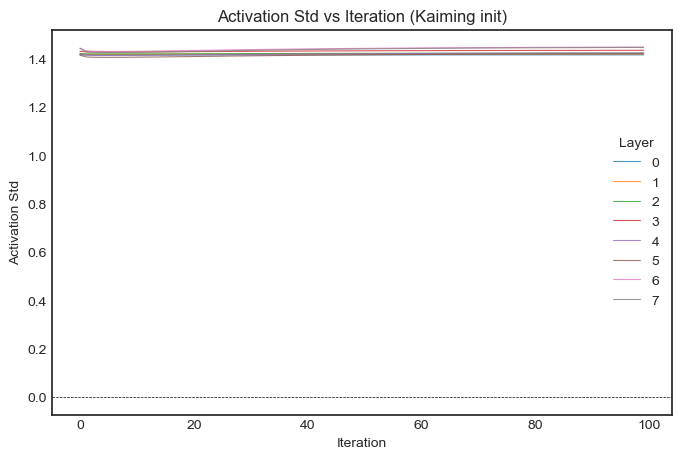

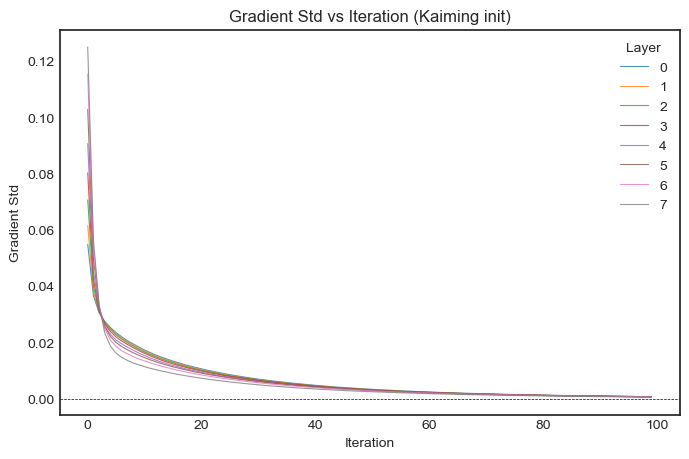

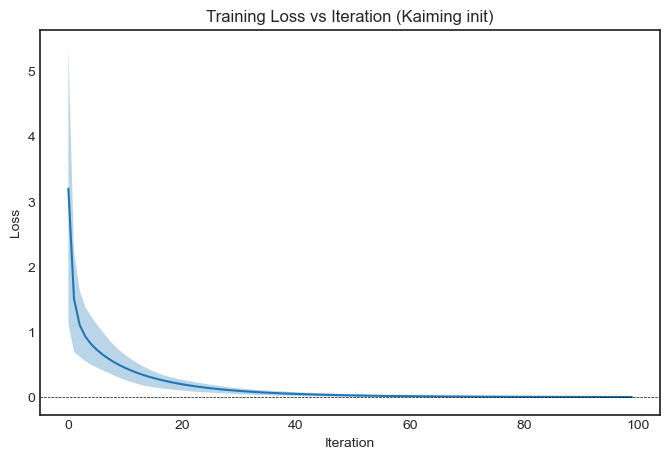

In [12]:
plot_activation_distribution_and_loss(initialization='kaiming',
                                      depth=8,
                                      width=256,
                                      iterations=100,
                                      trials=50)

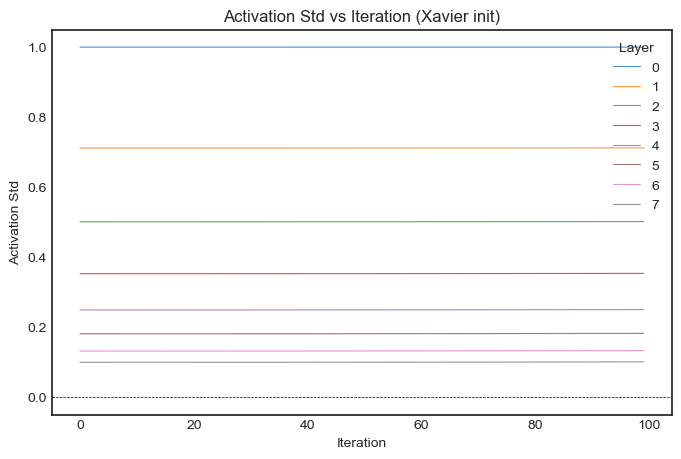

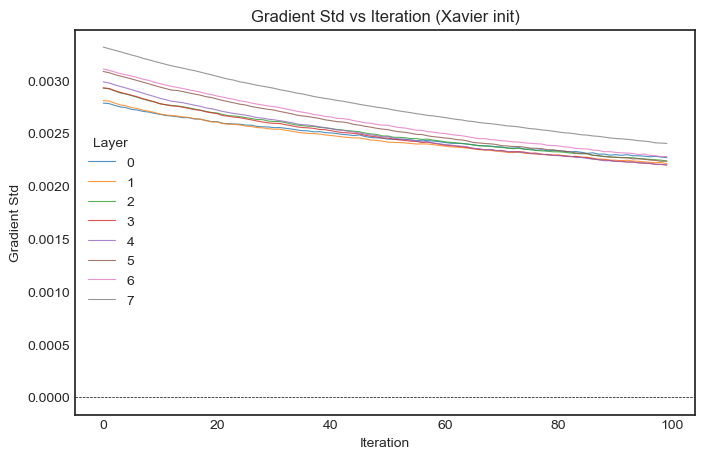

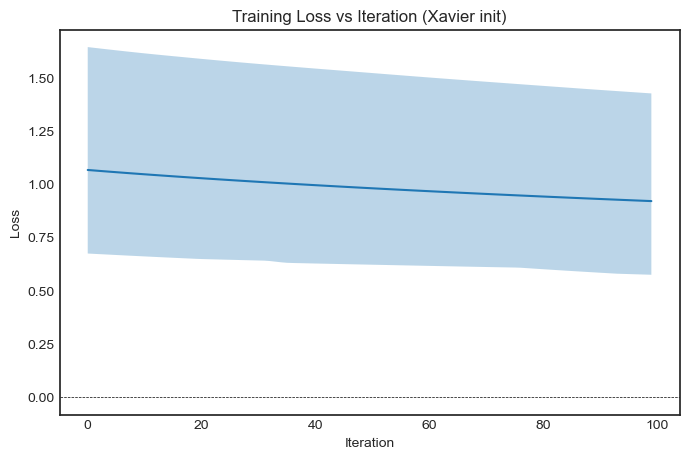

In [13]:
plot_activation_distribution_and_loss(initialization='xavier',
                                      depth=8,
                                      width=256,
                                      iterations=100,
                                      trials=50)

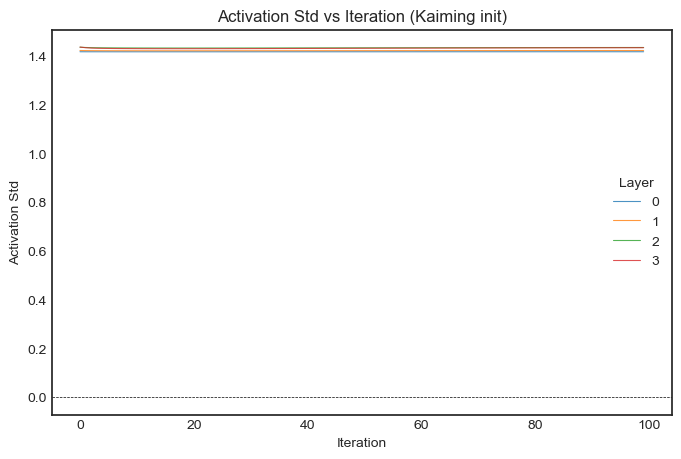

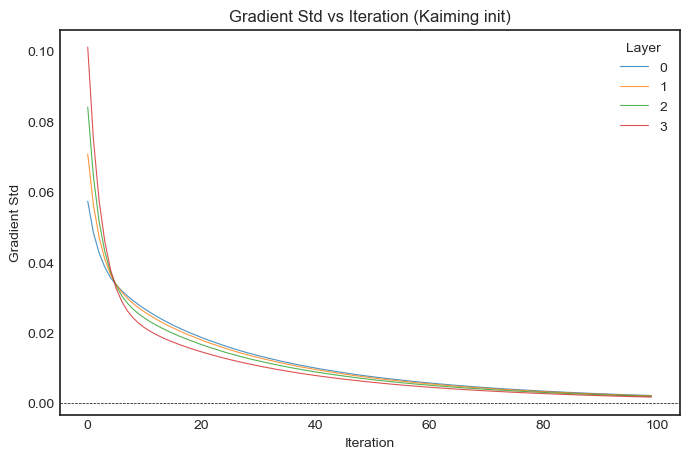

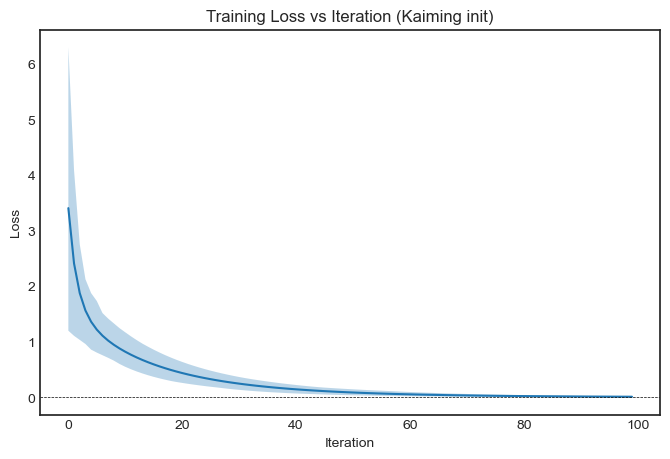

In [14]:
plot_activation_distribution_and_loss(initialization='kaiming',
                                      depth=4,
                                      width=256,
                                      iterations=100,
                                      trials=50)

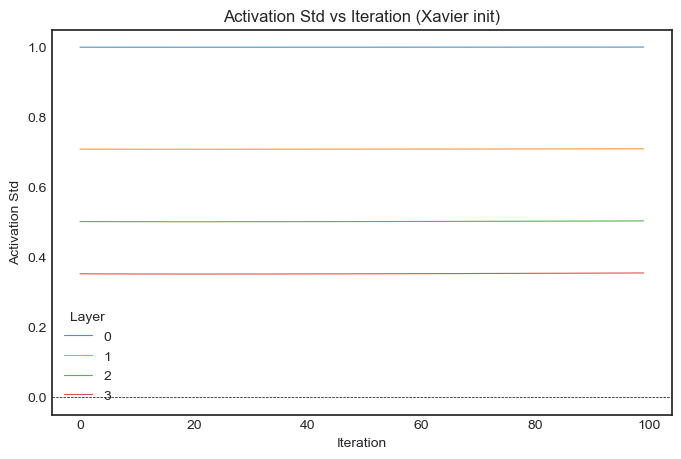

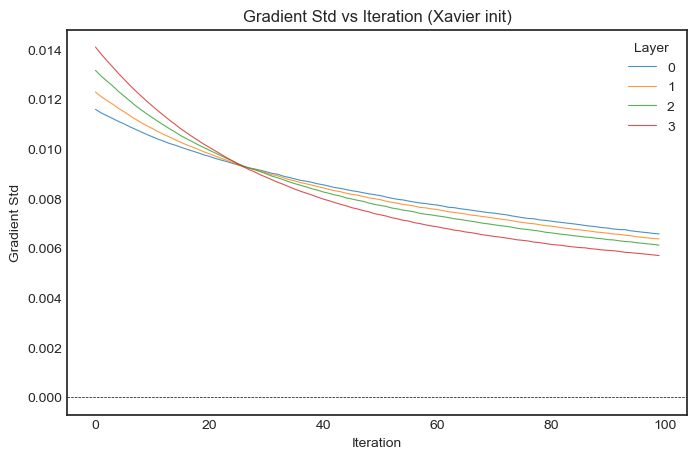

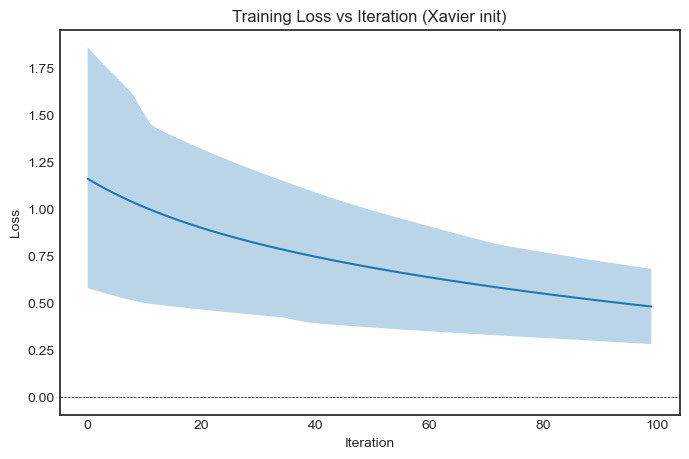

In [15]:
plot_activation_distribution_and_loss(initialization='xavier',
                                      depth=4,
                                      width=256,
                                      iterations=100,
                                      trials=50)